**DDA Ass4**

- Q1
Implement PCA and K-means from scratch.

Clear the dataset.

In [1]:
data = []
with open("seeds_dataset.txt", "r") as f:
    for line in f.readlines():
        line = line.strip('\n')
        line = line.split('\t')
        while "" in line:
            line.remove("")
        line = list(map(float, line))
        data.append(line)


Finish PCA part. According to the requirement, choose top 2 features, and $lowDMat$ is the coefficient matrix after PCA.

In [24]:
import numpy as np
import matplotlib.pyplot as plt

def pca(dataMat, topNfeat):
    meanVals = np.mean(dataMat, axis=0)
    meanRemoved = dataMat - meanVals  # substract its mean
    covMat = np.cov(meanRemoved, rowvar=False)
    eigVals, eigVets = np.linalg.eig(np.mat(covMat))  #calculate evalues and evectors
    eigValInd = np.argsort(eigVals)  
    eigValInd = eigValInd[:-(topNfeat + 1):-1]  
    redEigVects = eigVets[:, eigValInd]  
    lowDDatMat = meanRemoved * redEigVects  
    return lowDDatMat

topNfeat = 2
mat_data = np.mat(data)
lowDMat = pca(mat_data, topNfeat)

Finish K means. The number of clusters is set as 3. 

Firstly, random choose 3 points as initial centroids.

No handles with labels found to put in legend.


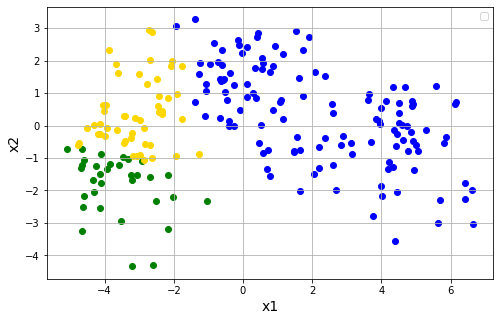

In [25]:
K = 3

def initCentroids(X, K):
    m = len(X)
    idx = np.random.choice(m, K)
    centroids = X[idx]  
    return centroids 

def findClosestCentroids(X, centroids):
    idx = []
    for i in range(len(X)):
        minus = X[i] - centroids  
        dist = np.multiply(minus[:,0],minus[:,0]) + np.multiply(minus[:,1],minus[:,1]) 
        ci = np.argmin(dist) 
        idx.append(ci)  
    return np.array(idx)  

def computeCentroids(X, idx): 
    centroids = []
    for i in range(len(np.unique(idx))): 
        u_k = X[idx==i].mean(axis=0) 
        centroids.append(u_k)
    return np.array(centroids)

def plotData(X, centroids, idx=None):
    
    colors = ['b','g','gold','darkorange','salmon','olivedrab', 
              'maroon', 'navy', 'sienna', 'tomato', 'lightgray', 'gainsboro'
             'coral', 'aliceblue', 'dimgray', 'mintcream', 'mintcream']  
    assert len(centroids[0]) <= len(colors), 'colors not enough '
    
    subX = []  
    if idx is not None:  
        for i in range(centroids[0].shape[0]): 
            x_i = X[idx == i]
            subX.append(x_i)  
    else:
        subX = [X]
    
    plt.figure(figsize=(8,5))    
    for i in range(len(subX)):
        xx = subX[i]
        for j in range(len(xx)):
            plt.scatter(xx[j,0], xx[j,1], c=colors[i])
    plt.legend()
    plt.grid(True)
    plt.xlabel('x1',fontsize=14)
    plt.ylabel('x2',fontsize=14)
    plt.show()


init_centroids = initCentroids(lowDMat, K)
idx = findClosestCentroids(lowDMat, init_centroids)
plotData(lowDMat, [init_centroids], idx)


Then repeat the procedure 20 times.

No handles with labels found to put in legend.


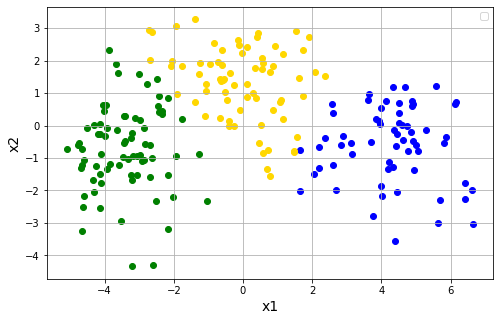

In [29]:
def runKmeans(X, centroids, max_iters):  
    centroids_all = []
    centroids_all.append(centroids)
    l_s = []
    for i in range(max_iters):
        idx = findClosestCentroids(X, centroids)
        s = SihouetteCoefficient(X, idx)
        l_s.append(s)
        centroids = computeCentroids(X, idx)
        centroids = centroids.reshape((3,2))
        centroids_all.append(centroids)
    
    return idx, centroids_all, l_s

idx_withIter, centroids_all, l_s = runKmeans(lowDMat, init_centroids, 20)
plotData(lowDMat, centroids_all, idx_withIter)

- Q2 Result Analysis

We use Sihouette coefficient and Rand index to evaluation our model.


Sihouette Coefficient

1. for each point $i$, calculate the average distance with other points in the same cluster, denoted as $a(i)$;
2. choose another cluster $b$, and calculate minimum distance among the distances with all points in cluster $b$, denoted as $b(i)$;
3. for point $i$, $s(i) = \frac{abs(b(i)-a(i))}{max(a(i),b(i))}$;
4. take the average of $s(i)$ as the final $s$.

The closer s is with 1, the better performance the model has.

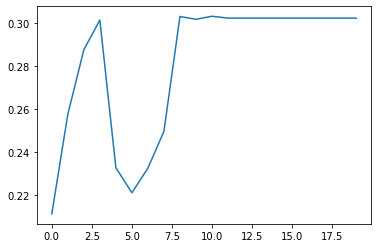

In [30]:
def SihouetteCoefficient(data, idx):
    # get the partition of cluster
    l1 = []
    l2 = []
    l3 = []
    for i in range(len(idx)):
        cat = idx[i]
        x = data[i, 0]
        y = data[i, 1]
        if cat == 0:
            l1.append([x,y])
        elif cat == 1:
            l2.append([x,y])
        else:
            l3.append([x,y])
    
    s1 = calculate(l1, l2, l3)
    s2 = calculate(l2, l1, l3)
    s3 = calculate(l3, l2, l1)
    return (s1+s2+s3)/3
    
def calculate(l1, l2, l3):
    s = 0
    for i in range(len(l1)):
        p = l1[i]

        #calculate a(i)
        a = 0
        for j in range(len(l1)):
            p1 = l1[j]
            a += distance(p, p1)
        a = a/len(l1)

        #calculate b(i)
        b1 = 0
        b2 = 0
        for j in range(len(l2)):
            p1 = l2[j]
            b1 += distance(p, p1)
        b1 = b1/len(l2)

        for j in range(len(l3)):
            p1 = l3[j]
            b2 += distance(p, p1)
        b2 = b2/len(l3)

        b = min(b1, b2)

        s = abs(b - a)/max(b, a)
        return s

def distance(p1, p2):
    return np.sqrt((p1[0]-p2[0])**2 + (p1[1] - p2[1])**2)

plt.plot(l_s)

The above figure shows the Sihouette coefficient in every iteration. It increases overall, which shows a positive optimization.

Rand Index

Rand index is a measure of the similarity between two data clusters. Given a set of n element $S$ = {$o_1, ..., o_n$} and two partitions of S to compare, $X$ = {$X_1, ..., X_r$} and $Y$ = {$Y_1, ..., Y_s$}, define the following:
- $ a$, the number of pairs of elements in $S$ that are in the same subset in $X$ and in the same subset in $Y$; 
- $b$, the number of pairs of elements in $S$ that are in different subset in $X$ and in different subset in $Y$.

The Rand index, $R$, is
$ R = \frac{a+b}{n(n-1)/2} $.

This involves the comparison of two different model. In this problem, we compare the result from the 1st iteration and the last (20th) one.

In [33]:
def RandIndex(idx, idx_withIter):
    n = 0
    l = len(idx)
    for i in range(l):
        cluster1 = idx[i]
        cluster2 = idx_withIter[i]
        for j in range(l):
            if idx[j] == cluster1 and idx_withIter[j] == cluster2:
                n += 1
            if idx[j] != cluster1 and idx_withIter[j] != cluster2:
                n += 1
    return 2*n/((l-1)*l)

r = RandIndex(idx, idx_withIter)
print("The Rand index of the two model is %f."%r)


The Rand index of the two model is 1.446708.
